In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=15, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-06-02 08:08:44,266 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cw4xnaic', purging
2023-06-02 08:08:44,267 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-z2h4jfhz', purging
2023-06-02 08:08:44,268 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-owze_ev3', purging
2023-06-02 08:08:44,268 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-pnu87tz_', purging
2023-06-02 08:08:44,269 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_66unwmo', purging
2023-06-02 08:08:44,270 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-hyxg19ht', purging
2023-06-02 08:08:44,270 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gzss2mqe', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 15
Total threads: 15,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38779,Workers: 15
Dashboard: http://127.0.0.1:8787/status,Total threads: 15
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:46743,Total threads: 1
Dashboard: http://127.0.0.1:41159/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:40963,


In [2]:
import geopandas as gpd
coastline = gpd.read_file('~/storage/VECTORIAL/limites/chilecontinental.gpkg')

/home/lucasg/miniconda3/envs/main/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
# Load grid
gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()

In [197]:
# Load control simulation 
preprocess = lambda ds: croco_sellonlatbox(ds[['temp','salt','u','v','zeta','h','Cs_r','hc','hbl']],  360-71.53, 360-71.22, -30, -29.75)
pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y*.nc'))
control_avg      = xr.open_mfdataset(pathsavg_control, parallel=True, preprocess=preprocess)
control_avg      = fix_crocotime(control_avg, YORIG='1949-12-30 23:59:50')
control_avg      = center_crocogrid(control_avg, control_avg.keys()).load()


In [198]:
grid = control_avg.h.where(control_avg.temp[0][0]!=0).sel(eta_rho=slice(150,450), xi_rho=slice(100,150)).isel(time=0)

In [205]:
# cross section
cross  = control_avg.sel(xi_rho=128).sel(eta_rho=slice(351,365))
zcross = rhopoints_depths(cross.h.expand_dims(dim={'s_rho':control_avg.s_rho}), cross.zeta, cross.s_rho, cross.Cs_r, cross.hc).load().rename('z')
target_depths = np.arange(0.5,50+0.25,0.25)
husk = xgcm.Grid(cross, coords={'z':{'center':'s_rho'}}, periodic=False)
temp = husk.transform(cross.temp,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
salt = husk.transform(cross.salt,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
u = husk.transform(cross.u,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)
v = husk.transform(cross.v,'z',-target_depths, target_data=zcross, method='linear', mask_edges=False)


cross = xr.merge([u,v,temp,salt,cross.h[0], cross.hbl])
distance = list(zip(cross.lat_rho.values, 360-cross.lon_rho.values))
distance = [haversine(distance[0], d) for d in distance]
cross.coords['distance'] = ('eta_rho', np.array(distance))
# del u,v,temp,salt,zcross,husk,target_depths

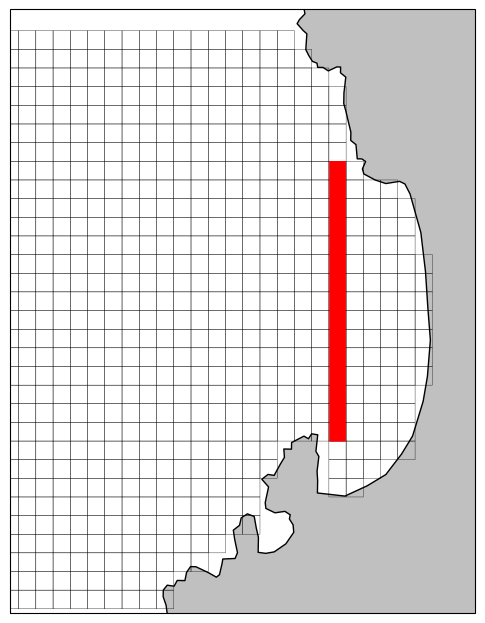

In [104]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8), facecolor='w', dpi=100)
ax.set_extent([-71.5,-71.25,-30.01,-29.75])
coastline.plot(ax=ax, color='silver', edgecolor='k')
ax.pcolor(grid.lon_rho, grid.lat_rho, grid, facecolor='none', edgecolor='k')
ax.pcolor(cross.lon_rho, cross.lat_rho, cross.h.expand_dims({'xi_rho':15}), facecolor='none', edgecolor='red', lw=11)


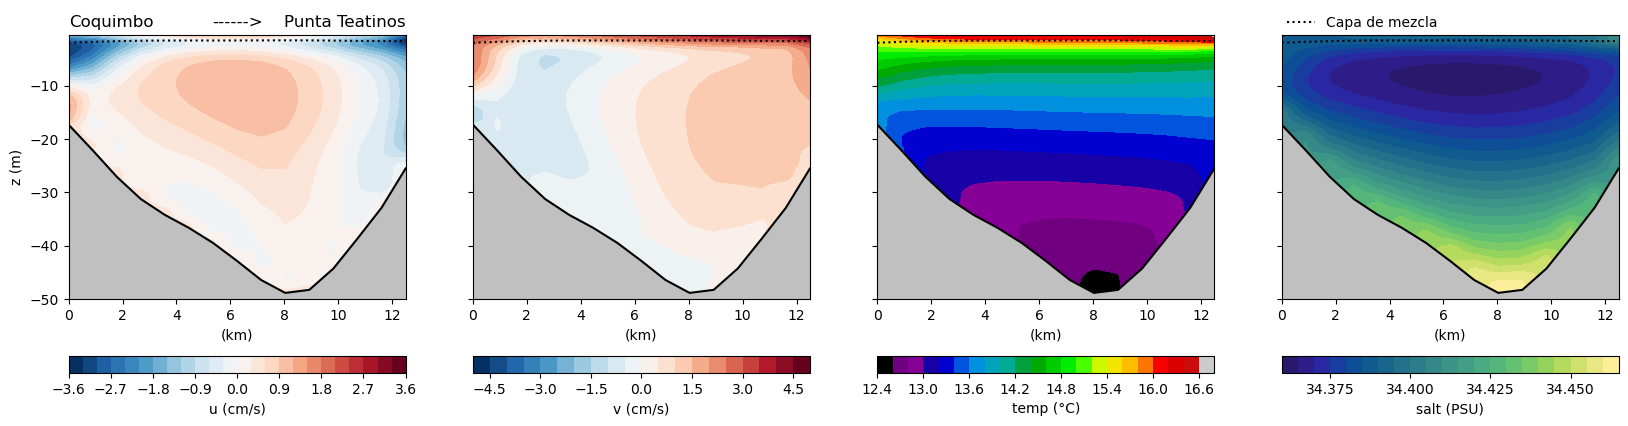

In [215]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(20,5), facecolor='w', dpi=100)


(cross.u.mean('time')*100).plot.contourf(levels=25,x='distance', y='z', ax=ax[0], zorder=0, cbar_kwargs={'label':'u (cm/s)','orientation':'horizontal'})
(cross.v.mean('time')*100).plot.contourf(levels=25,x='distance', y='z', ax=ax[1], zorder=0, cbar_kwargs={'label':'v (cm/s)','orientation':'horizontal'})
(cross.temp.mean('time')).plot.contourf(levels=25,x='distance', y='z', ax=ax[2], zorder=0, cbar_kwargs={'label':'temp (°C)','orientation':'horizontal'}, cmap='nipy_spectral')
(cross.salt.mean('time')).plot.contourf(levels=25,x='distance', y='z', ax=ax[3], zorder=0, cbar_kwargs={'label':'salt (PSU)','orientation':'horizontal', 'ticks':np.arange(34.30, 34.46, 0.025)}, cmap=cmocean.cm.haline)

for i,axis in enumerate(ax.ravel()):
    (-cross.hbl.mean('time')).plot(ax=axis, color='k', ls=':', x='distance', label='Capa de mezcla')
    axis.fill_between(cross['distance'], -cross.h,
                      -np.ones(len(cross.h))*50,
                      zorder=1, color='silver')
    axis.plot(cross['distance'], -cross.h, color='k')
    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('(km)')
ax[0].set_ylabel('z (m)')
ax[0].set_title('Coquimbo', loc='left')
ax[0].set_title('------>', loc='center')
ax[0].set_title('Punta Teatinos', loc='right')
ax[-1].legend(loc=(0,1), frameon=False)



In [217]:
seasonality = cross.groupby('time.season').mean().sel(season=['DJF', 'MAM', 'JJA', 'SON'])

u DJF
u MAM
u JJA
u SON
v DJF
v MAM
v JJA
v SON
temp DJF
temp MAM
temp JJA
temp SON
salt DJF
salt MAM
salt JJA
salt SON


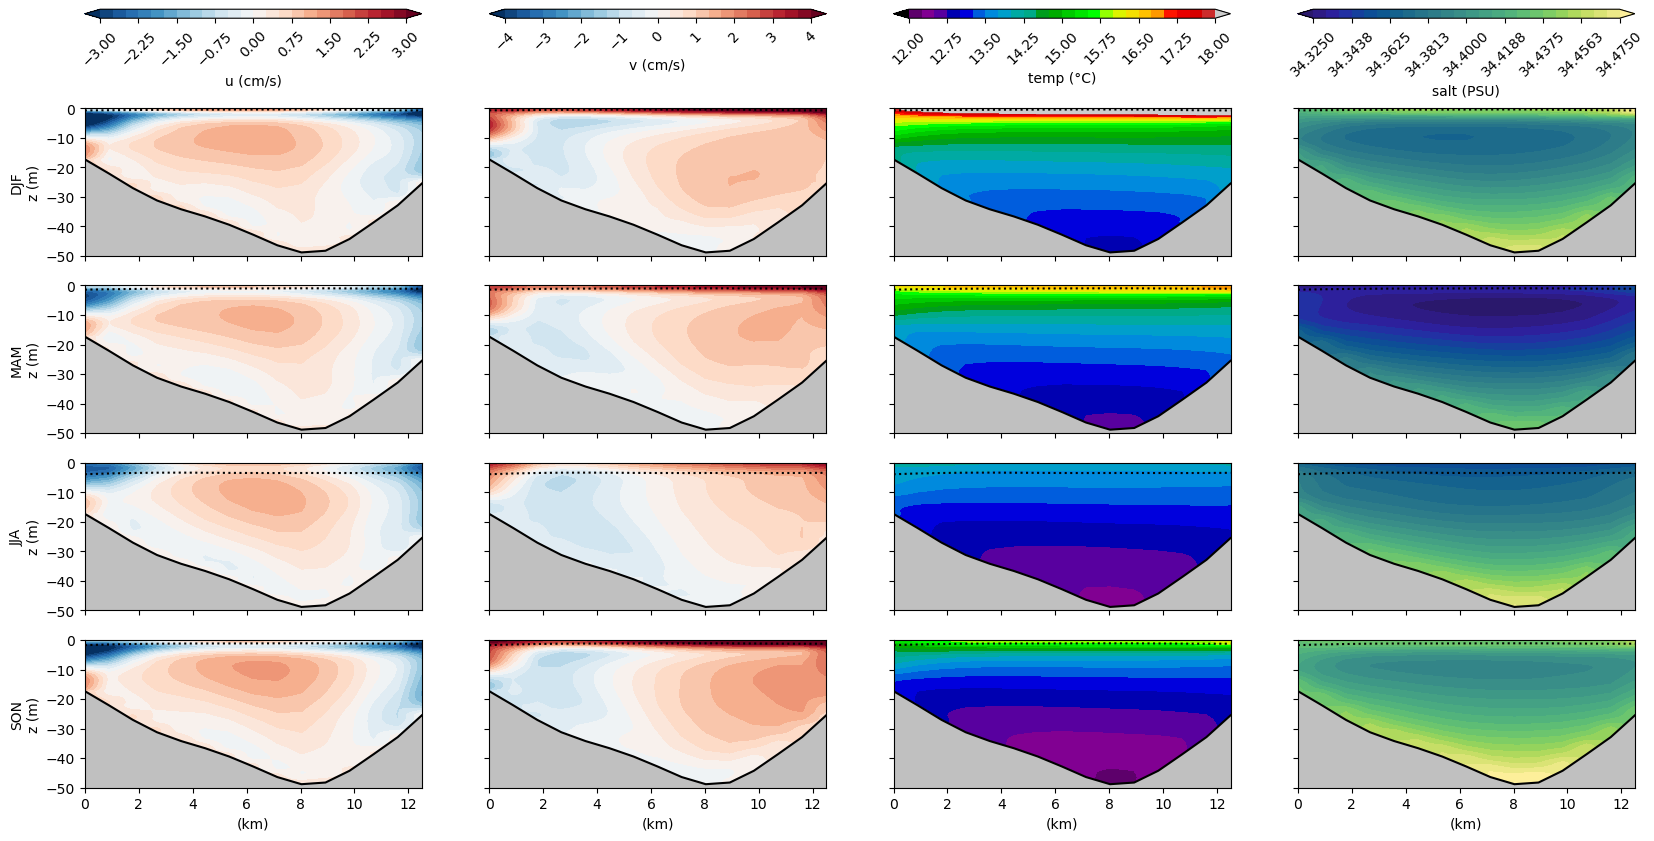

In [244]:
fig, ax = plt.subplots(4,4, sharex=True, sharey=True, figsize=(20,9), facecolor='w', dpi=100)

variables = ['u','v','temp','salt']
seasons   = ['DJF','MAM','JJA','SON']
cmaps     = ['RdBu_r', 'RdBu_r', 'nipy_spectral', cmocean.cm.haline]
vmins     = [-3,-4, 12, 34.325]
vmaxs     = [3, 4, 18, 34.475]
titles    = ['u (cm/s)', 'v (cm/s)', 'temp (°C)', 'salt (PSU)']
for j in range(len(ax[:,0])):
    var = variables[j]
    cmap = cmaps[j]
    vmin,vmax = vmins[j],vmaxs[j]
    for i in range(len(ax[0,:])):
        season = seasons[i]
        
        print(var, season)
        axis = ax[i,j]
        if var=='u' or var=='v':
            field = seasonality[var].sel(season=season)*100
            m=field.plot.contourf(levels=25,x='distance', y='z', ax=axis, zorder=0, add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
        else:
            field = seasonality[var].sel(season=season)
            m=field.plot.contourf(levels=25,x='distance', y='z', ax=axis, zorder=0, add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')

        (-seasonality.hbl.sel(season=season)).plot(ax=axis, color='k', ls=':', x='distance')
        axis.fill_between(cross['distance'], -cross.h,
                        -np.ones(len(cross.h))*50,
                        zorder=1, color='silver')
        axis.plot(cross['distance'], -cross.h, color='k')
        axis.set_title('')
        axis.set_ylabel('')
        if j == 0:
            axis.set_ylabel('{}\nz (m)'.format(season))
        if i == len(ax[:,0])-1:
            axis.set_xlabel('(km)')
        else:
            axis.set_xlabel('')
        axis.set_ylim(-50,0)
    box = ax[0,j].get_position()
    cax = fig.add_axes([box.xmin, box.ymax+0.1, box.xmax-box.xmin, 0.01])
    cbar = fig.colorbar(m, cax=cax, orientation='horizontal', label=titles[j])
    cbar.ax.tick_params(axis='x', rotation=45)

### eof analysis

In [245]:
from sklearn.decomposition import PCA

In [107]:
baseline = cross.resample({'time':'m'}).mean()
baseline['time'] = baseline['time']-pd.Timedelta(days=16)
baseline = baseline.resample({'time':'d'}).interpolate(kind='cubic').reindex({'time':cross.time.values}, method='nearest')
baseline

<xarray.Dataset>
Dimensions:   (time: 1826, eta_rho: 15, z: 199)
Coordinates:
  * time      (time) datetime64[ns] 2001-01-01T12:00:00 ... 2005-12-31T12:00:00
    xi_rho    float32 128.0
  * eta_rho   (eta_rho) float32 351.0 352.0 353.0 354.0 ... 363.0 364.0 365.0
    lon_rho   (eta_rho) float32 288.7 288.7 288.7 288.7 ... 288.7 288.7 288.7
    lat_rho   (eta_rho) float32 -29.93 -29.92 -29.92 ... -29.84 -29.83 -29.82
  * z         (z) float64 -0.5 -0.75 -1.0 -1.25 ... -49.25 -49.5 -49.75 -50.0
    distance  (eta_rho) float64 0.0 0.8924 1.785 2.677 ... 9.819 10.71 11.6 12.5
Data variables:
    u         (time, eta_rho, z) float64 0.0008198 -0.006625 ... 0.00279 0.00279
    v         (time, eta_rho, z) float64 0.02652 0.02469 ... 0.006299 0.006299
    temp      (time, eta_rho, z) float64 17.74 17.5 17.26 ... 13.28 13.28 13.28
    salt      (time, eta_rho, z) float64 34.41 34.41 34.41 ... 34.45 34.45 34.45
    h         (time, eta_rho) float64 17.31 22.1 27.06 ... 38.64 32.87 25.5

Text(0, 0.5, '°C')

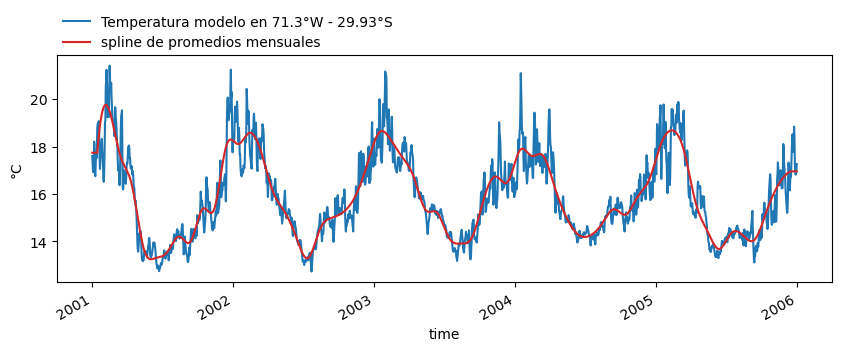

In [128]:
plt.figure(figsize=(10,3), facecolor='w', dpi=100)
cross.temp.isel(eta_rho=0, z=0).plot(label='Temperatura modelo en 71.3°W - 29.93°S')
baseline.temp.isel(eta_rho=0, z=0).plot(color='tab:red', label='spline de promedios mensuales')
plt.title('')
plt.legend(loc=(0,1), frameon=False)
plt.ylabel('°C')

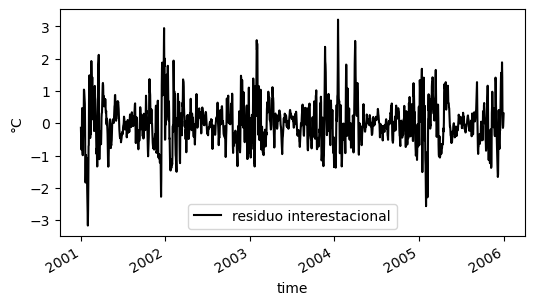

In [137]:
plt.figure(figsize=(6,3), facecolor='w', dpi=100)
(cross-baseline).temp.isel(eta_rho=0, z=0).plot(label='residuo interestacional', color='k')
plt.title('')
plt.ylabel('°C')
plt.legend()

In [108]:
cross_sanomaly = (cross-baseline).sel(time='2003')
eofmatrix_u = cross_sanomaly.u.data.reshape(len(cross_sanomaly.time), 15*199)
pca   = PCA(n_components=5, whiten=False).fit(eofmatrix_u,)
pc_u  = pca.transform(eofmatrix_u)
r2_u  = pca.explained_variance_ratio_

eofmatrix_v = cross_sanomaly.v.data.reshape(len(cross_sanomaly.time), 15*199)
pca   = PCA(n_components=5, whiten=False).fit(eofmatrix_v)
pc_v  = pca.transform(eofmatrix_v)
r2_v  = pca.explained_variance_ratio_

eofmatrix_temp = cross_sanomaly.temp.data.reshape(len(cross_sanomaly.time), 15*199)
pca      = PCA(n_components=5, whiten=False).fit(eofmatrix_temp)
pc_temp  = pca.transform(eofmatrix_temp)
r2_temp  = pca.explained_variance_ratio_

eofmatrix_salt = cross_sanomaly.salt.data.reshape(len(cross_sanomaly.time), 15*199)
pca      = PCA(n_components=5, whiten=False).fit(eofmatrix_salt)
pc_salt  = pca.transform(eofmatrix_salt)
r2_salt  = pca.explained_variance_ratio_

pc_u    = xr.DataArray(pc_u, coords={'time':cross_sanomaly.time.values,'comp':range(5)})
pc_v    = xr.DataArray(pc_v, coords={'time':cross_sanomaly.time.values,'comp':range(5)})
pc_temp = xr.DataArray(pc_temp, coords={'time':cross_sanomaly.time.values,'comp':range(5)})
pc_salt = xr.DataArray(pc_salt, coords={'time':cross_sanomaly.time.values,'comp':range(5)})

eof_u      = xr.corr(pc_u, cross_sanomaly.u, 'time')
eof_v      = xr.corr(pc_v, cross_sanomaly.v, 'time')
eof_temp   = xr.corr(pc_temp, cross_sanomaly.temp, 'time')
eof_salt   = xr.corr(pc_salt, cross_sanomaly.salt, 'time')

/tmp/ipykernel_15646/1381257323.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(['EOF{}'.format(int(x)) for x in ax[i].get_xticks()])


Text(0, 0.5, 'Fraccion de varianza explicada (-)')

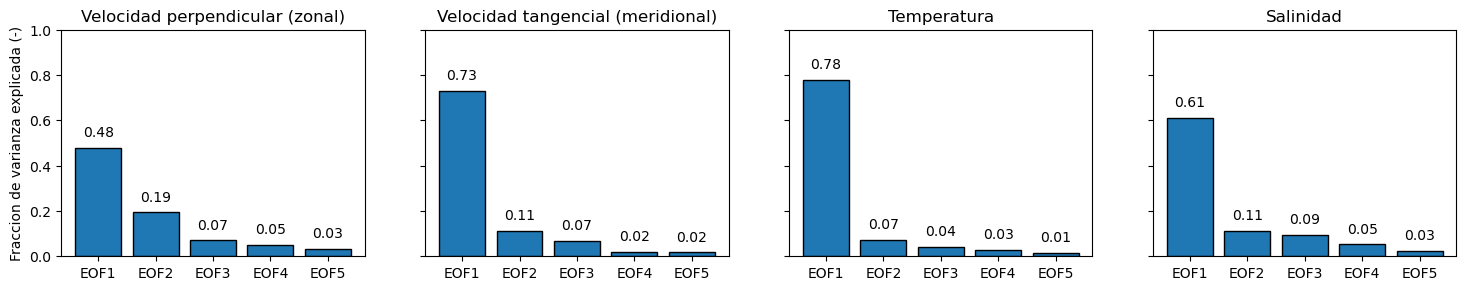

In [161]:
fig, ax = plt.subplots(1,4, figsize=(18,3), facecolor='w', dpi=100, sharey=True, sharex=True)
titles=['Velocidad perpendicular (zonal)', 'Velocidad tangencial (meridional)', 'Temperatura', 'Salinidad']
for i,var in enumerate(['u','v','temp','salt']):
    ax[i].set_title(titles[i])
    r2  = eval('r2_'+var)
    ax[i].bar(np.arange(1,1+len(r2)), r2, edgecolor='k')
    for j in range(len(r2)):
        ax[i].text(j+1, r2[j]+0.05, '{:.2f}'.format(r2[j]), ha='center')
    ax[i].set_ylim(0,1)
    ax[i].set_xticklabels(['EOF{}'.format(int(x)) for x in ax[i].get_xticks()])
ax[0].set_ylabel('Fraccion de varianza explicada (-)')


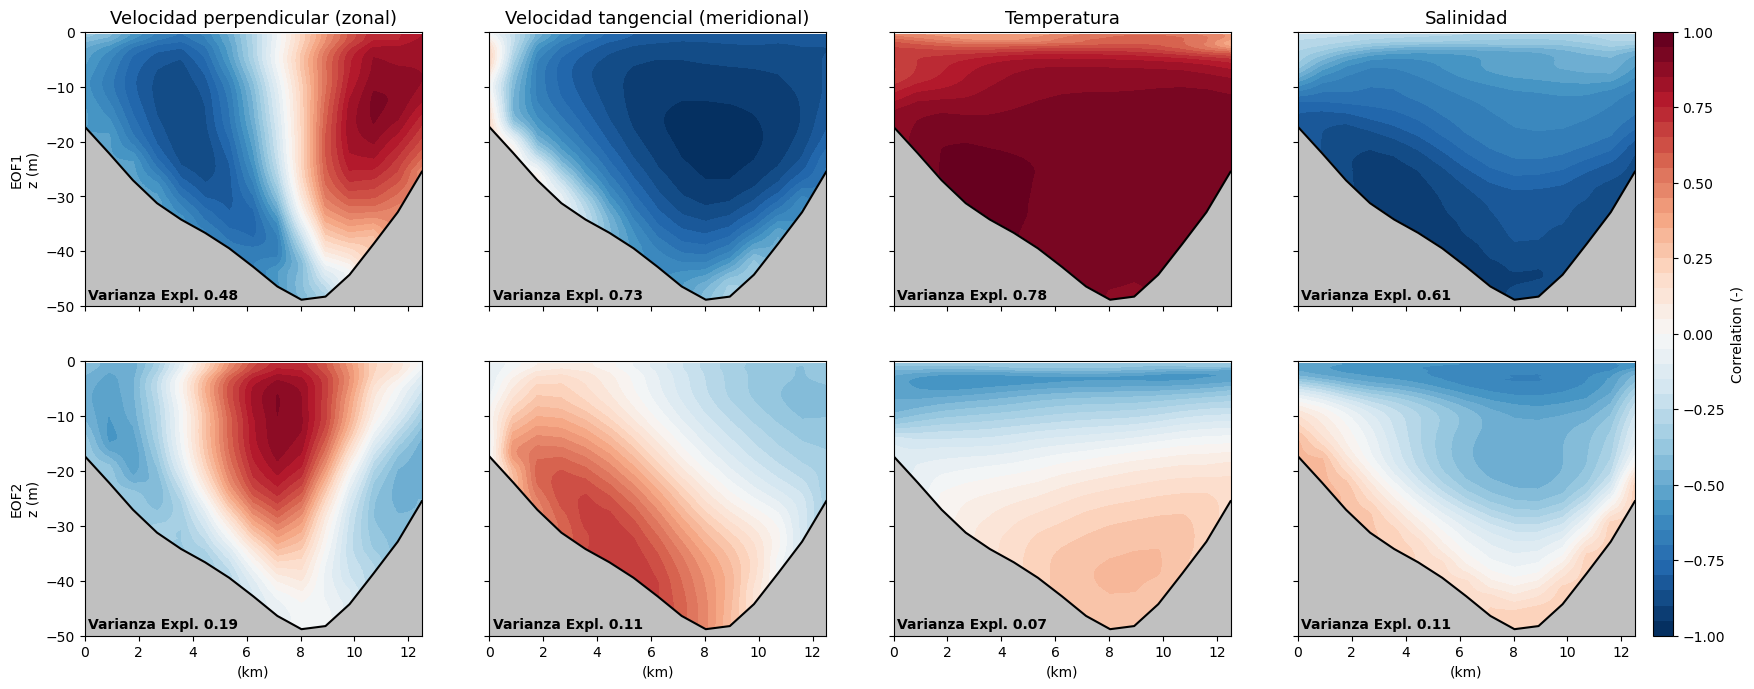

In [16]:
fig, ax = plt.subplots(2,4, sharex=True, sharey=True, figsize=(20,8), facecolor='w', dpi=100)

titles=['Velocidad perpendicular (zonal)', 'Velocidad tangencial (meridional)', 'Temperatura', 'Salinidad']
for i,var in enumerate(['u','v','temp','salt']):
    eof = eval('eof_'+var)
    r2  = eval('r2_'+var)
    
    for comp in range(2):
        m = eof.isel(comp=comp).plot.contourf(ax=ax[comp,i], cmap='RdBu_r', levels=np.arange(-1,1+0.05,0.05),
                                          add_colorbar=False, x='distance', y='z')
        ax[comp,i].text(0.01,0.025,'Varianza Expl. {:.2f}'.format(r2[comp]), transform=ax[comp,i].transAxes, weight='bold')


for i,axis in enumerate(ax.ravel()):
    axis.fill_between(cross['distance'], -cross.h,
                      -np.ones(len(cross.h))*50,
                      zorder=1, color='silver')
    axis.plot(cross['distance'], -cross.h, color='k')
    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.set_xlim(cross.distance[0], cross.distance[-1])
    axis.set_ylim(-50,0)
    
for i,axis in enumerate(ax[:,0]):
    axis.set_ylabel('EOF{}\nz (m)'.format(i+1))
    
for i,axis in enumerate(ax[0,:]):
    axis.set_title(titles[i], fontsize=13)
    
for axis in ax[-1,:]:
    axis.set_xlabel('(km)')
    
box1 = ax[0,-1].get_position()
box2 = ax[-1,-1].get_position()
cax = fig.add_axes([box1.xmax*1.01,box2.ymin,0.01,box1.ymax-box2.ymin])
fig.colorbar(m,cax=cax, label='Correlation (-)')

## EOF currentsd and with all variables normalized

In [309]:
from scipy.cluster.vq import whiten
cross_sanomaly = (cross-baseline).sel(time='2003')
eofmatrix      = cross_sanomaly.u.data.reshape(len(cross_sanomaly.time), 15*199),cross_sanomaly.v.data.reshape(len(cross_sanomaly.time), 15*199)#,cross_sanomaly.temp.data.reshape(len(cross_sanomaly.time), 15*199),cross_sanomaly.salt.data.reshape(len(cross_sanomaly.time), 15*199)
eofmatrix      = np.hstack(eofmatrix)
# eofmatrix = whiten(eofmatrix)
pca   = PCA(n_components=5, whiten=False).fit(eofmatrix)
pc  = pca.transform(eofmatrix)
r2  = pca.explained_variance_ratio_

pc  = xr.DataArray(pc, coords={'time':cross_sanomaly.time.values,'comp':range(5)})


In [351]:
cross_sanomaly.isel(eta_rho=5)

<xarray.Dataset>
Dimensions:   (time: 365, z: 199)
Coordinates:
    xi_rho    float32 128.0
    eta_rho   float32 356.0
    lon_rho   float32 288.7
    lat_rho   float32 -29.89
  * time      (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-12-31T12:00:00
  * z         (z) float64 -0.5 -0.75 -1.0 -1.25 ... -49.25 -49.5 -49.75 -50.0
    distance  float64 4.462
Data variables:
    u         (time, z) float64 -0.01251 -0.01083 ... 0.0001091 0.0001091
    v         (time, z) float64 0.02378 0.02409 0.02462 ... -0.00948 -0.00948
    temp      (time, z) float64 -0.08603 0.03416 0.1595 ... -0.3306 -0.3306
    salt      (time, z) float64 -0.01748 -0.01619 -0.01471 ... 0.01499 0.01499
    h         (time) float64 7.105e-15 0.0 0.0 ... -7.105e-15 0.0 -7.105e-15

In [363]:
288.7-360

-71.30000000000001

In [362]:
cross_sanomaly.isel(eta_rho=5)

<xarray.Dataset>
Dimensions:   (time: 365, z: 199)
Coordinates:
    xi_rho    float32 128.0
    eta_rho   float32 356.0
    lon_rho   float32 288.7
    lat_rho   float32 -29.89
  * time      (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-12-31T12:00:00
  * z         (z) float64 -0.5 -0.75 -1.0 -1.25 ... -49.25 -49.5 -49.75 -50.0
    distance  float64 4.462
Data variables:
    u         (time, z) float64 -0.01251 -0.01083 ... 0.0001091 0.0001091
    v         (time, z) float64 0.02378 0.02409 0.02462 ... -0.00948 -0.00948
    temp      (time, z) float64 -0.08603 0.03416 0.1595 ... -0.3306 -0.3306
    salt      (time, z) float64 -0.01748 -0.01619 -0.01471 ... 0.01499 0.01499
    h         (time) float64 7.105e-15 0.0 0.0 ... -7.105e-15 0.0 -7.105e-15

Text(0.5, 1.0, '')

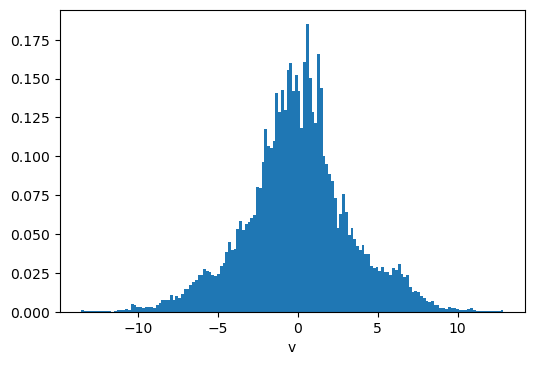

In [374]:
plt.figure(facecolor='w', dpi=100)
(100*cross_sanomaly).isel(eta_rho=5).v.plot.hist(bins='auto', density=True);
plt.title('')

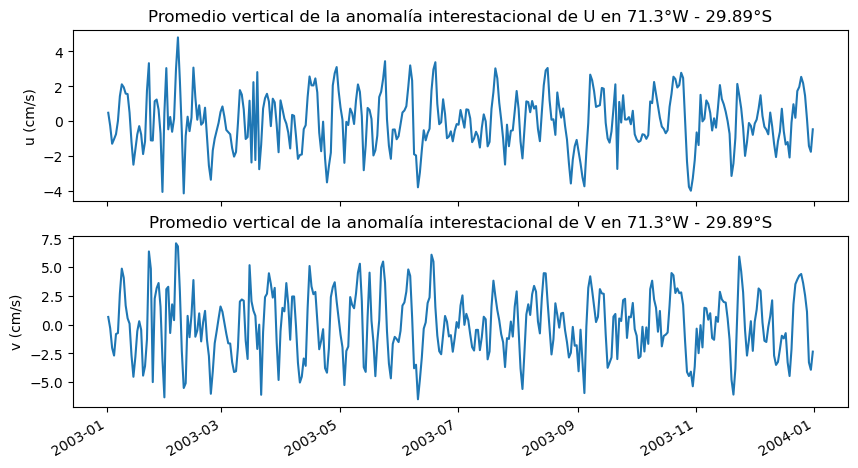

In [367]:
fig, ax = plt.subplots(2,1, figsize=(10,5), facecolor='w', dpi=100, sharex=True)

(100*cross_sanomaly).isel(eta_rho=5).mean('z').u.plot(ax=ax[0])
(100*cross_sanomaly).isel(eta_rho=5).mean('z').v.plot(ax=ax[1])

ax[0].set_title('Promedio vertical de la anomalía interestacional de U en 71.3°W - 29.89°S')
ax[1].set_title('Promedio vertical de la anomalía interestacional de V en 71.3°W - 29.89°S')
ax[0].set_ylabel('u (cm/s)')
ax[1].set_ylabel('v (cm/s)')

for axis in ax:
    axis.set_xlabel('')


/tmp/ipykernel_15646/2579381174.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EOF{}'.format(int(x)) for x in ax.get_xticks()])


Text(0.5, 1.0, 'Fraccion de varianza explicada  EOF conjunta U,V')

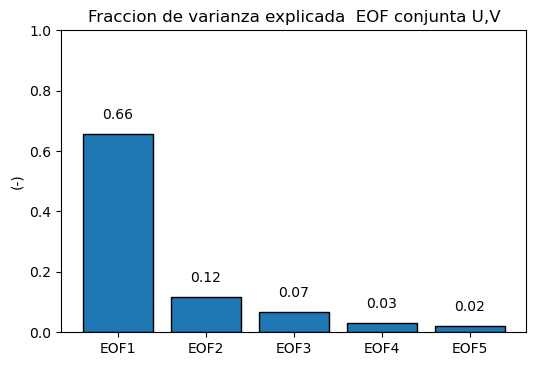

In [311]:
fig = plt.figure(facecolor='w', dpi=100)
ax  = fig.add_subplot(111)
ax.bar(range(1,6), r2, edgecolor='k')

for j in range(5):
    ax.text(j+1, r2[j]+0.05, '{:.2f}'.format(r2[j]), ha='center')
ax.set_ylim(0,1)
ax.set_xticklabels(['EOF{}'.format(int(x)) for x in ax.get_xticks()])
ax.set_ylabel('(-)')
ax.set_title('Fraccion de varianza explicada  EOF conjunta U,V')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Valor PC')

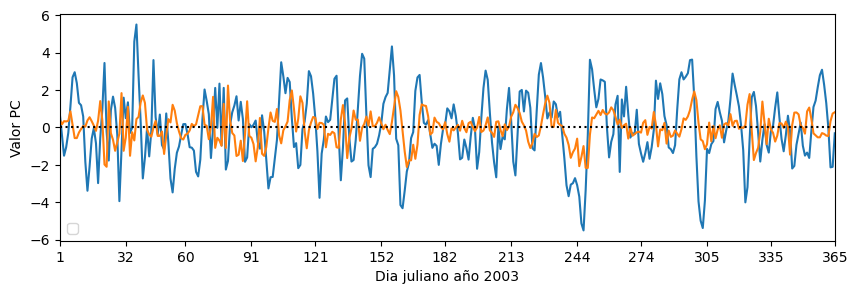

In [341]:
fig, ax = plt.subplots(1,1, facecolor='w', dpi=100, figsize=(10,3))
for i in range(2):
    ax.plot(np.arange(1,366), pc.isel(comp=i))
ax.set_xlim(1,365)
ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335,365]);
ax.set_xlabel('Dia juliano año 2003')
ax.legend(ncol=2, loc='lower left')
ax.axhline(0, color='k', ls=':')
ax.set_ylabel('Valor PC')

/tmp/ipykernel_15646/847370464.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1/f,S)


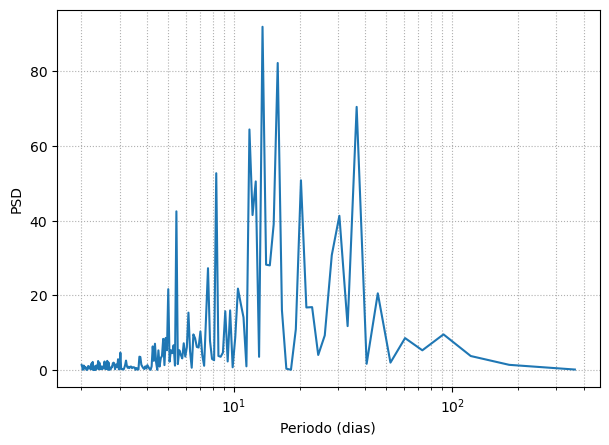

In [339]:
from scipy.signal import periodogram
(f, S) = periodogram(pc.sel(comp=0).values,)
fig, ax = plt.subplots(1,1, figsize=(7,5), facecolor='w', dpi=100)
plt.semilogx(1/f,S)
plt.xlabel('Periodo (dias)')
plt.ylabel('PSD')
plt.grid(ls=":", which='both')

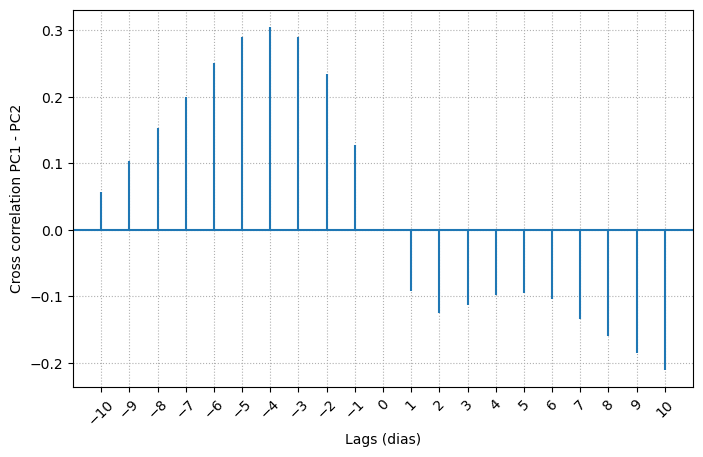

In [307]:
fig, ax = plt.subplots(1,1, facecolor='w', dpi=100, figsize=(8,5))
ax.xcorr(pc.isel(comp=0), pc.isel(comp=2));
ax.set_ylabel('Cross correlation PC1 - PC2')
ax.set_xticks(np.arange(-10,10+1));
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Lags (dias)')
ax.grid(ls=":")

In [305]:
eof_u         = xr.corr(pc, cross_sanomaly.u, 'time')
eof_v         = xr.corr(pc, cross_sanomaly.v, 'time')
eof_temp      = xr.corr(pc, cross_sanomaly.temp, 'time')
eof_salt      = xr.corr(pc, cross_sanomaly.salt, 'time')

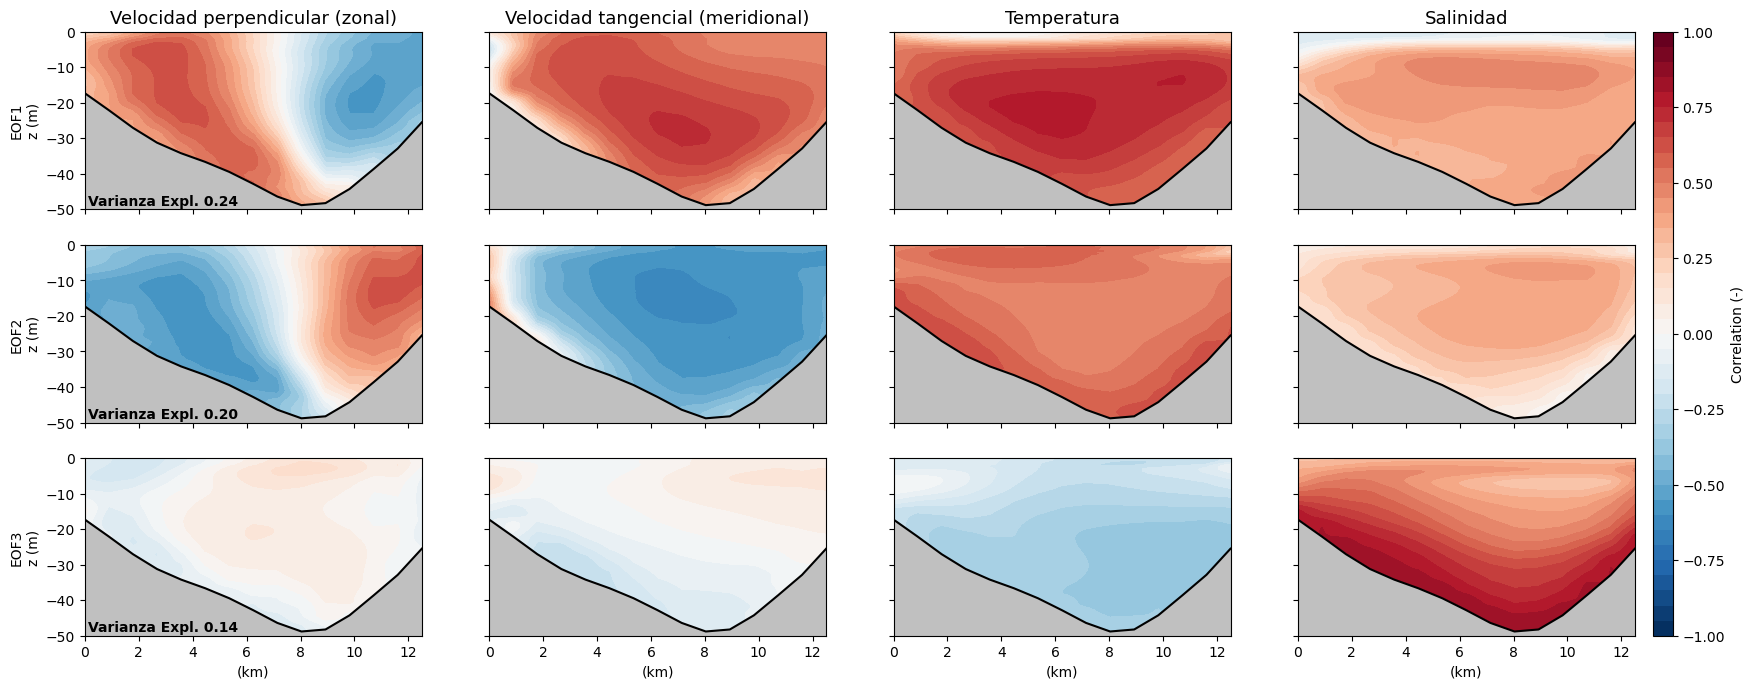

In [308]:
fig, ax = plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,8), facecolor='w', dpi=100)

titles=['Velocidad perpendicular (zonal)', 'Velocidad tangencial (meridional)', 'Temperatura', 'Salinidad']
for i,var in enumerate(['u','v','temp','salt']):
    eof = eval('eof_'+var)
    r2  = r2
    
    for comp in range(3):
        m = eof.isel(comp=comp).plot.contourf(ax=ax[comp,i], cmap='RdBu_r', levels=np.arange(-1,1+0.05,0.05),
                                          add_colorbar=False, x='distance', y='z')
        ax[comp,0].text(0.01,0.025,'Varianza Expl. {:.2f}'.format(r2[comp]), transform=ax[comp,i].transAxes, weight='bold')


for i,axis in enumerate(ax.ravel()):
    axis.fill_between(cross['distance'], -cross.h,
                      -np.ones(len(cross.h))*50,
                      zorder=1, color='silver')
    axis.plot(cross['distance'], -cross.h, color='k')
    axis.set_title('')
    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.set_xlim(cross.distance[0], cross.distance[-1])
    axis.set_ylim(-50,0)
    
for i,axis in enumerate(ax[:,0]):
    axis.set_ylabel('EOF{}\nz (m)'.format(i+1))
    
for i,axis in enumerate(ax[0,:]):
    axis.set_title(titles[i], fontsize=13)
    
for axis in ax[-1,:]:
    axis.set_xlabel('(km)')
    
box1 = ax[0,-1].get_position()
box2 = ax[-1,-1].get_position()
cax = fig.add_axes([box1.xmax*1.01,box2.ymin,0.01,box1.ymax-box2.ymin])
fig.colorbar(m,cax=cax, label='Correlation (-)')